# Clasificador de imágenes de Charge Current Quasi Elastic interactions(CCQE: signal) vs backgrounds con CNN en SBND


En este proyecto se estudia el problema de clasificación binaria de imagenes (señal vs ruido)utilizando como datos de entrada simulaciones de eventos dentro del Short Baseline Neutrino Experiment (SBND). El objetivo es entrenar una CNN para separar imagenes de eventos donde se ha producido una interacción cargada cuasi-elástica (CCQE) del resto. Como imput se utiliza las imágenes producidas dentro de la Liquid Argon Time Projection Chamber (LArTPC) al leer la señal generada por los electrones en los wire planes de los laterales.

## Explorando los datos
Se descargan los datos en un fichero zip con 45 000 eventos con interacciones de neutrinos dentro del experimento SBND simulados dentro del framework de [LArSoft](https://larsoft.org/). Para la producción de los neutrinos se emplea el [generador MC Genie](https://github.com/GENIE-MC/Generator), mientras que la simulación de la propagación e interacción de los fotones y electrones dentro del argón se modela utilizando [GEANT 4](https://geant4.web.cern.ch/node/1). En la simulación se almacena la información Truth de la interacción que luego nos permite identificar las imágenes de cada evento como CCQE(señal) o background.


In [16]:
# !wget --no-check-certificate \
#     https://www.dropbox.com/s/jsrm05t6xy61f5y/CNN_CCQE_background_discriminator.data.zip?dl=0 \
#     -O /tmp/CNN_CCQE_background_discriminator_data.zip

# import zipfile
# local_zip = '/tmp/CNN_CCQE_background_discriminator_data.zip'
# zip_ref = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall('/tmp/CNN_CCQE_background_discriminator_data/')
# zip_ref.close()

--2021-12-02 14:26:16--  https://www.dropbox.com/s/jsrm05t6xy61f5y/CNN_CCQE_background_discriminator.data.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/jsrm05t6xy61f5y/CNN_CCQE_background_discriminator.data.zip [following]
--2021-12-02 14:26:17--  https://www.dropbox.com/s/raw/jsrm05t6xy61f5y/CNN_CCQE_background_discriminator.data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0d69aa9862cf8682082051544b.dl.dropboxusercontent.com/cd/0/inline/BbF0d5YxIh_BpPesmgfFKeeHEcSZaRFk5u23J5dPH2YX9Edzhf-8SbQiGrcN9IQkKe2NVEXMPthk0qbk4se3imglEXEXlPT-ZfNrcRvgJGy8gg14TFr4HmxkqNkpq8UuockkLjQoX1xvEuzh72BtpZwo/file# [following]
--2021-12-02 14:26:17--  https://uc0d69aa9862cf8682082051544b.dl.dropboxusercontent.com/cd/0/in

In [1]:
# !pip install uproot #needed to read root files/trees
# !pip install awkward #needed for uproot to implement lazy arrays(memory isn't infine!)

import uproot
import awkward
import os
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import PercentFormatter
import collections



### Comentarios generales de los datos
Los datos se han repartido por comodidad en 11 archivos en formato .root, conteniendo cada uno 4200 eventos. Las imágenes se guardan como vectores de números decimales(floats). El módulo uproot provee la interfaz básica para leer los datos en formato .root y convertirlos a numpy arrays.

In [2]:
file_path="NNDumper_Data/NNDumper_tree_00.root"
file = uproot.open(file_path)
tree = file["nndumper"]["evttree;5"] 
print("Contenido del TTree:")
tree.show()


Contenido del TTree:
name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
TPCImgDataU          | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
TPCImgWidthU         | int32_t                  | AsDtype('>i4')
TPCImgHeightU        | int32_t                  | AsDtype('>i4')
TPCImgDataV          | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
TPCImgWidthV         | int32_t                  | AsDtype('>i4')
TPCImgHeightV        | int32_t                  | AsDtype('>i4')
TPCImgDataY          | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
TPCImgWidthY         | int32_t                  | AsDtype('>i4')
TPCImgHeightY        | int32_t                  | AsDtype('>i4')
OpImgData0           | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
OpImgData1           | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
OpImgWidth           |

In [3]:
lazyarray = uproot.lazy(file_path+":nndumper/evttree;5")
NEvents=len(lazyarray)
h_TPC_U=lazyarray[0] ["TPCImgHeightU"]
w_TPC_U=lazyarray[0] ["TPCImgWidthU"]
h_TPC_V=lazyarray[0] ["TPCImgHeightV"]
w_TPC_V=lazyarray[0] ["TPCImgWidthV"]
h_TPC_Y=lazyarray[0] ["TPCImgHeightY"]
w_TPC_Y=lazyarray[0] ["TPCImgWidthY"]

w_Opt=lazyarray[0] ["OpImgWidth"]
h_Opt=lazyarray[0] ["OpImgHeight"]
i_type=lazyarray[0]["InteractionType"]


print("Numero de eventos en el .root file: ",NEvents)
print("Tamaño de las imagenes de TPC:",w_TPC_U,"x",h_TPC_U)
print("Tamaño de las imagenes opticas:",w_Opt,"x",h_Opt)#hay 96 canales ópticos, pero por simplicidad para la CNN colapsamos los canales enfrentados en el mismo: ch(6+7)...->96/2=48
print("Nº de canales opticos de PMT coated (VUV+VIS):",len(lazyarray[0]["SimPhotonsData"].to_numpy()))
print("Tipo de interaccion:",i_type,"1001=ChargeCurrentQuasiElastic (CCQE->Señal)") #1001 CCQE, lo demás, backgrounds (mirar interaction.png, cada numero es una interacción distinta)

Numero de eventos en el .root file:  4200
Tamaño de las imagenes de TPC: 248 x 200
Tamaño de las imagenes opticas: 48 x 600
Nº de canales opticos de PMT coated (VUV+VIS): 96
Tipo de interaccion: 1008 1001=ChargeCurrentQuasiElastic (CCQE->Señal)


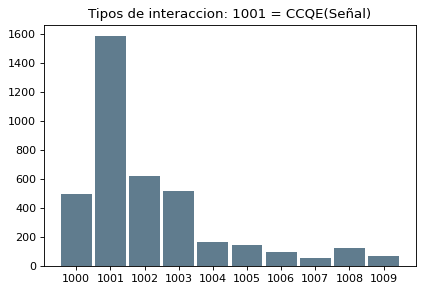

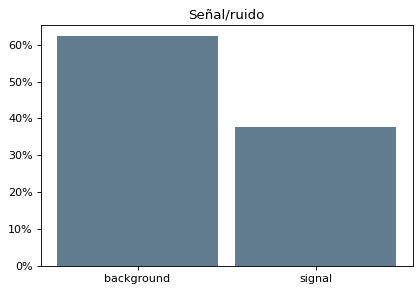

In [4]:
i_type=[];
picture_label=[]
for i in range(NEvents):
    i_type.append(lazyarray[i]["InteractionType"]);
    if(i_type[i]==1001):
      picture_label.append("signal")
    else:
      picture_label.append("background")

plt.figure(figsize=( 6,4), dpi=80);
plt.hist(i_type,10,[999.5,1009.5],color='#607c8e',rwidth=0.9)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
plt.title("Tipos de interaccion: 1001 = CCQE(Señal)")

plt.figure(figsize=( 6,4), dpi=80);
plt.title("Señal/ruido")
plt.hist(picture_label,2,range=[-0.5,1.5],density=True,color='#607c8e',rwidth=0.9)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

#Renombramos señal con 1 y ruido con 0:
picture_label=[1 if x=="signal" else 0 for x in picture_label]


Separamos en 66% / 33% los eventos para entrenamiento y validación. Los datos están ya mezclados, por lo que basta con separarlos.

In [5]:
picture_label_validation=picture_label[:1400]
picture_label_train     =picture_label[1400:]
collections.Counter(picture_label)[1]
c_train     =collections.Counter(picture_label_train)
c_validation=collections.Counter(picture_label_validation)

In [6]:

print('total training signal images:', c_train[1])
print('total training background images:', c_train[0])
print('proporción señal/ruido: ', int(c_train[1]/(c_train[1]+c_train[0])*100),int(c_train[0]/(c_train[1]+c_train[0])*100))
print('\n')
print('total validation signal images:', collections.Counter(picture_label_validation)[1])
print('total validation background images:', collections.Counter(picture_label_validation)[0])
print('proporción señal/ruido: ', int(c_validation[1]/(c_validation[1]+c_validation[0])*100),int(c_validation[0]/(c_validation[1]+c_validation[0])*100))


total training signal images: 1094
total training background images: 1706
proporción señal/ruido:  39 60


total validation signal images: 490
total validation background images: 910
proporción señal/ruido:  35 65


(4200, 200, 248)


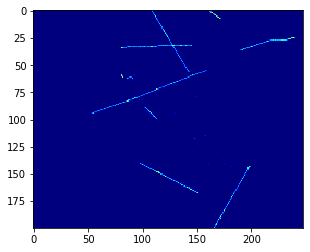

In [7]:
h=lazyarray[0] ["TPCImgHeightU"]
w=lazyarray[0] ["TPCImgWidthU"]

file   = uproot.open(file_path)
tree   = file["nndumper/evttree;5"]
branch = tree["TPCImgDataU"]
pics=branch.array().to_numpy().reshape(4200,h,w)#images are stored as vectors, switch them back to matrices again
pics/=np.max(pics) #normalize to 1.

print(pics.shape)
plt.imshow(pics[0],cmap = 'jet', interpolation='none');

In [8]:
labels  = tree["InteractionType"].array().to_numpy()
labels2 = labels==1001
labels3 = labels2.astype(int)
labels3

array([0, 1, 1, ..., 1, 0, 0])

In [9]:
labels3_validation=labels3[:1400]
labels3_train     =labels3[1400:]

pics_validation=pics[:1400,:,:]
pics_train     =pics[1400:,:,:]

## Definición de la CNN 

Las imágenes color se escalan a tamaño image_size X image_size píxeles, aunque en realidad son objetos 150x150x3 debido a los 3 colores RGB.

In [10]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import applications


### Toy model

In [17]:
# Capa de entrada de datos: image_size x image_size x 1
img_input = layers.Input(shape=(h, w, 1))

# Bloque convolucional formado por: 
# Capa convolucional con 16 filtros y tamaño 3x3.
# Capa max-pooling de tamaño 2x2.
x = layers.Conv2D(6, 5, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Bloque convolucional formado por: 
# Capa convolucional con 32 filtros y tamaño 3x3.
# Capa max-pooling de tamaño 2x2.
x = layers.Conv2D(12, 5, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
# A continuación se añaden dos capas densas, 
# la primera de las cuales tiene una función de activación relu. 
# Finalmente la capa de salida tiene una sola neurona para producir 
# un único escalar con función de activación sigmoide para producir 
# una salida en el rango entre 0 y 1.

# Se aplana el objeto de forma que en vez se tener un tensor 3D sea 1D.
x = layers.Flatten()(x)
# Capa de salida de una única neurona y función de activación sigmoide.
output = layers.Dense(1, activation='sigmoid')(x)

for x in model.layers:
  print(x.output_shape)


[(None, 200, 248, 1)]
(None, 195, 243, 16)
(None, 97, 121, 16)
(None, 92, 116, 32)
(None, 46, 58, 32)
(None, 41, 53, 64)
(None, 20, 26, 64)
(None, 15, 21, 128)
(None, 7, 10, 128)
(None, 8960)
(None, 32)
(None, 1)


In [18]:
# Crear el modelo:
model = Model(img_input, output)

In [21]:
# Entrenar el modelo.
from tensorflow.keras.optimizers import RMSprop

# model.compile(loss='binary_crossentropy',
#               optimizer=RMSprop(lr=0.001),
#               metrics=['acc'])
loss='binary_crossentropy',optimizer='adam'model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 248, 1)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 196, 244, 6)       156       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 98, 122, 6)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 94, 118, 12)       1812      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 47, 59, 12)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 33276)             0   

### Transfer learning - Deep model -> can not use onlly one layer (h,w,1), only 3 RGB pictures alowed (h,w,3)

In [81]:
# Se carga la parte convolucional del modelo entrenado VGG16.
# Very Deep Convolutional Networks for Large-Scale Image Recognition
# Karen Simonyan, Andrew Zisserman
# https://arxiv.org/abs/1409.1556

conv_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(h,w,3) )

# Se añaden una capa flatten,
x = layers.Flatten()(conv_model.output)
# varias capas densas 
# (a medida que se añadan más capas densas el tiempo de entrenamiento se incrementa)
x = layers.Dense(10, activation='relu')(x)
#x = layers.Dense(100, activation='relu')(x)
#x = layers.Dense(100, activation='relu')(x)
# y una capa final softmax 
predictions = layers.Dense(2, activation='softmax', name='dense_output')(x)
# puesto que nuestro problema es un clasificador binario (gatos-perros)
# la capa de salida debe tener dos neuronas con softmax como función de activación.

# Crear el modelo completo
full_model = Model(inputs=conv_model.input, outputs=predictions)
full_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200, 248, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 248, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 248, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 124, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 124, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 124, 128)     147584    
                                                            

### Dani model

In [85]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D , Dropout , Flatten, Dense

# parameters
filters=6
kernel_size=5
pool=2
dropout=0.1

#convolutional block
model = keras.models.Sequential()

model.add(Conv2D(6, 5,activation='relu',data_format="channels_first",input_shape=(pics.shape[1],pics.shape[2],1)))
model.add(MaxPooling2D(pool_size=(2,2),data_format='channels_first'))
model.add(Dropout(dropout))
print(model.layers[-1].output_shape)

model.add(Conv2D(12, 4,activation='relu',data_format="channels_first",input_shape=(pics.shape[1],pics.shape[2],1)))
model.add(MaxPooling2D(pool_size=(2,2),data_format='channels_first'))
model.add(Dropout(dropout))
print(model.layers[-1].output_shape)


model.add(Flatten())
print(model.layers[-1].output_shape)

model.add(Dense(1,activation='sigmoid'))
print(model.layers[-1].output_shape)

ValueError: ignored

### Entrenamiento

In [40]:
history=model.fit(pics_train,labels3_train, epochs=3, batch_size=32, validation_data=(pics_validation,labels3_validation), verbose=1)

Epoch 1/3
88/88 [==============================] - 31s 348ms/step - loss: 0.6744 - acc: 0.6093 - val_loss: 0.6568 - val_acc: 0.6500
Epoch 2/3
88/88 [==============================] - 34s 385ms/step - loss: 0.6735 - acc: 0.6093 - val_loss: 0.6483 - val_acc: 0.6500
Epoch 3/3
88/88 [==============================] - 34s 387ms/step - loss: 0.6726 - acc: 0.6093 - val_loss: 0.6478 - val_acc: 0.6500


## Visualización de las representaciones intermedias

Se visualiza las características intermedias aprendidas por la CNN. Se puede observar como la entrada se transforma al pasar através de las capas. Se selecciona una imagen aleatoria del conjunto de entrenamiento y se visualiza durante su transformación. Cada fila corresponde con una capa y cada imagen en la fila con un filtro. 

In [ ]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Se define un nuevo modelo que tendrá como entrada la imagen, 
# y como salida la representación intermedia de todas las capas. 
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = Model(img_input, successive_outputs)

x = pics[48]  # Array Numpy array con dimensiones (1, image_size, image_size, 3)

# Reescalar por 1/255
x /= 255

# Se hace pasar la imagen através de la red. 
# Así se obtienen sus presentaciones intermedias. 
successive_feature_maps = visualization_model.predict(x)

# Se obtienen los nombres de las capas. 
layer_names = [layer.name for layer in model.layers]

# Dibjar representaciones
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Hacer con las capas convolucionales y max-pooling, pero no con las densas
    n_features = feature_map.shape[-1]  # número de características en un mapa
    # El mapa tiene dimensiones (1, size, size, n_features)
    size = feature_map.shape[1]
    # Título en las imágenes 
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Reprocesar para hacer visualizable 
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # Horizontal display 
      display_grid[:, i * size : (i + 1) * size] = x
    # Mostrar 
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

ValueError: ignored

## Evaluar la calidad del modelo

### Error y exactitud.
Se representan el error y la exactitud para los conjuntos de entrenamiento y validación.

Text(0.5, 1.0, 'Training and validation loss')

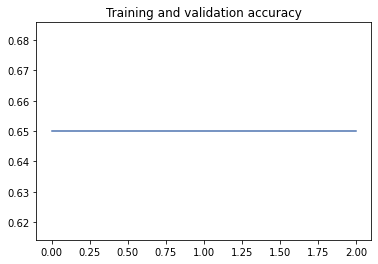

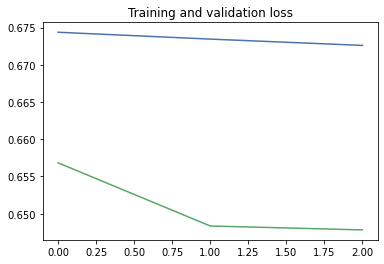

In [41]:
# Se recuperan el error y la exactitud de los conjuntos de 
# entrenamiento y validación 
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Número de épocas
epochs = range(len(acc))

# Representación de la exactitud por época de los conjutos de 
# entrenamiento y validación plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Representación del error por época de los conjutos de 
# entrenamiento y validación 
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [42]:
Y_pred = model.predict(pics_validation)

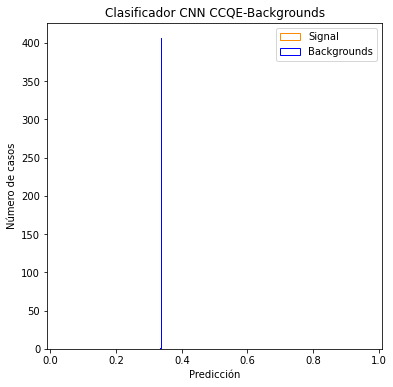

In [43]:
# Visualización de los pronósticos.
plt.figure(1,figsize=(6,6)) 
plt.style.use('seaborn-deep') 
plt.hist(Y_pred[labels3_validation==1],30,histtype='step',color='darkorange', label= "Signal")
plt.hist(Y_pred[labels3_validation==0],30,histtype='step',color='blue', label= "Backgrounds")
plt.ylabel('Número de casos')
plt.xlabel('Predicción')
plt.title("Clasificador CNN CCQE-Backgrounds")
plt.xlim(-0.01,1.01)
plt.legend( loc='upper right')
# plt.semilogx()
#from google.colab import files
#plt.savefig('ClasificadorCNNPerrosGatos.eps')
#files.download('ClasificadorCNNPerrosGatos.eps') # Descomentar para descargar localmente

### Matrix de confusión
La matrix de confusión es un sistema para evaluar la calidad de la predicción en resultados categóricos. 

In [44]:
from sklearn.metrics import classification_report, confusion_matrix

Se generan las etiquetas de las imágenes del conjunto de validación. Primero los valores numéricos del pronósitico, el cual es separado en dos vectores iguales. La primera mitad corresponde a los gatos y la segunda mitad a los perros. Finalmente se transforma los valores numéricos en el rango de 0 a 1, en etiquetas 0 ó 1, en función si es menor o mayor de 0.5. Este umbral es completamente arbitrario.

In [45]:
Y_pred_signal     = Y_pred[labels3_validation==1]
Y_pred_background = Y_pred[labels3_validation==0]

In [46]:
Y_pred[Y_pred<=0.5] = 0
Y_pred[Y_pred>0.5] = 1

Se construye el vector que corresponde con las etiquetas originales del conjunto de validación

In [47]:
Y_label_ori= labels3_validation

In [48]:
cm=confusion_matrix(Y_label_ori, Y_pred)
print(cm)

[[910   0]
 [490   0]]


In [49]:
# Trues
TP = cm[1,1]; print(TP)
TN = cm[0,0]; print(TN)
# Falses
FP = cm[0,1]; print(FP)  
FN = cm[1,0]; print(FN)

0
910
0
490


In [50]:
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print('Sensitivity or true positive rate',TPR)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
print('Specificity or true negative rate',TNR)
# Precision or positive predictive value
PPV = TP/(TP+FP)
print('Precision or positive predictive value',np.round(PPV,3))
# Negative predictive value
NPV = TN/(TN+FN)
print('Negative predictive value',np.round(NPV,3))
# Fall out or false positive rate
FPR = FP/(FP+TN)
print('False positive rate',FPR)
# False negative rate
FNR = FN/(TP+FN)
print('False negative rate',FPR)
# False discovery rate
FDR = FP/(TP+FP)
print('False discovery rate',FDR)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print('Accuracy',ACC)

Sensitivity or true positive rate 0.0
Specificity or true negative rate 1.0
Precision or positive predictive value nan
Negative predictive value 0.65
False positive rate 0.0
False negative rate 0.0
False discovery rate nan
Accuracy 0.65


<ipython-input-50-3657d7146356>:8: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP/(TP+FP)
<ipython-input-50-3657d7146356>:20: RuntimeWarning: invalid value encountered in long_scalars
  FDR = FP/(TP+FP)


## Propuestas adicionales.

*   Observar el sobreajuste producido si se sube el número de época, por ejemplo a 25. 
*   Modificar el número de filtros y bloques convolucionales para mejorar el rendimiento de la red. 
*   Si el tamaño de las imágenes se hace mucho más pequeño, cómo cambia el rendimiento del clasificador. ¿Y en la dirección contraria? 


